<a href="https://colab.research.google.com/github/Tahsinul7/ASL-Alphabet-detection/blob/main/AmericanSignLanguageDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms,models,datasets 
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_set_path = './drive/MyDrive/ASL_train'

In [4]:
## Transforming images
transform = transforms.Compose(
    [ 
        transforms.Resize((224,224)),
        transforms.ToTensor(), #Converting to tensors
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])#Normalizing 
    ]
)
data_set= torchvision.datasets.ImageFolder(data_set_path, transform) #preprocessing 
#Final_test_data_set = torchvision.datasets.ImageFolder('./drive/MyDrive/ASL_test',transform)

In [5]:
#Checking Random Image Shape and its label.
img, label = data_set[67777]
print(img.shape, label)

torch.Size([3, 224, 224]) 22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  W (22)


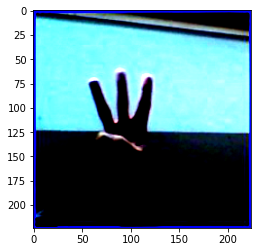

In [6]:
#Plotting the Image
def show_example(img, label):
    print('Label: ', data_set.classes[label], "("+str(label)+")")
    plt.imshow((img.permute(1, 2, 0)))

show_example(*data_set[67777])

In [7]:
val_size = 3000
test_size = 14000
train_size = len(data_set) - val_size - test_size

train_ds, val_ds, test_ds = random_split(data_set, [train_size, val_size, test_size])

print(len(train_ds), len(val_ds), len(test_ds))

70010 3000 14000


In [8]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [9]:
# Checking image shape after passing through data loader
sample = next(iter(train_loader))
img, label = sample

print(img.shape) #Batch Size is now shown as 64


torch.Size([64, 3, 224, 224])


In [10]:
#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### **Using Custom Convolutional Neural Net**


In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Declare all the layers for feature extraction
        self.features = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1), 
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1), 
                                      nn.MaxPool2d(2, 2), nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, padding=1),
                                      nn.MaxPool2d(2, 2), nn.ReLU(inplace=True))
        
        # Declare all the layers for classification
        self.classifier = nn.Sequential(nn.Linear(56*56*40, 1024), nn.ReLU(inplace=True),
                                       	nn.Linear(1024, 2048), nn.ReLU(inplace=True),
                                        nn.Linear(2048, 29))
        
    def forward(self, x):
      
        # Apply the feature extractor in the input
        x = self.features(x)
        
        # Squeeze the three spatial dimensions in one
        x = x.view(-1, 56 * 56* 40)
        
        # Classify the images
        x = self.classifier(x)
        return x


In [12]:
model = Net().to(device)

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 3

In [14]:
#tTraining
for epoch in tqdm(range(num_epochs)):

  losses = []
  
  for batch_idx, (data,targets) in enumerate(train_loader):
    data = data.to(device = device)
    targets = targets.to(device = device)
   


    #forward
    scores = model(data)
    loss =  criterion(scores,targets)
    losses.append(loss.item())

    #backward
    optimizer.zero_grad() #resets gradients to zero after each batch
    loss.backward() #

    # gradient descent or update
    optimizer.step()


  mean_loss = sum(losses)/ len(losses)
  print(f'Loss at epoch {epoch} was {mean_loss: .5f}')


def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0

  model.eval() #set evaluation.

  with torch.no_grad():#since evaluating telling pytorch not to calcuate gradients again
    for x,y in loader:
      x = x.to(device= device)
      y= y.to(device = device)
      
      

      scores = model(x)
      _,predictions = scores.max(1)
      num_correct += (predictions == y).sum()
      num_samples +=  predictions.size(0)

    print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

  

check_accuracy(train_loader,model)



 33%|███▎      | 1/3 [1:10:31<2:21:02, 4231.12s/it]

Loss at epoch 0 was  0.67382


 67%|██████▋   | 2/3 [1:17:10<51:21, 3081.49s/it]  

Loss at epoch 1 was  0.10205


100%|██████████| 3/3 [1:23:54<00:00, 1678.27s/it]

Loss at epoch 2 was  0.05979


Got 69008 / 70010 with accuracy 98.57


In [15]:
check_accuracy(val_loader,model)

Got 2918 / 3000 with accuracy 97.27


In [16]:
check_accuracy(test_loader,model)

Got 13636 / 14000 with accuracy 97.40


### **VGG 16**

In [17]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
model.fc = nn.Linear(in_features = 4096, out_features = 29) #Changing Linear Layer for our Outptul Class

In [19]:
model.to(device) #Moving Model to GPU

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [21]:
#tTraining
for epoch in tqdm(range(num_epochs)):

  losses = []
  
  for batch_idx, (data,targets) in enumerate(train_loader):
    data = data.to(device = device)
    targets = targets.to(device = device)
   


    #forward
    scores = model(data)
    loss =  criterion(scores,targets)
    losses.append(loss.item())

    #backward
    optimizer.zero_grad() #resets gradients to zero after each batch
    loss.backward() #

    # gradient descent or update
    optimizer.step()


  mean_loss = sum(losses)/ len(losses)
  print(f'Loss at epoch {epoch} was {mean_loss: .5f}')


def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0

  model.eval() #set evaluation.

  with torch.no_grad():#since evaluating telling pytorch not to calcuate gradients again
    for x,y in loader:
      x = x.to(device= device)
      y= y.to(device = device)
      
      

      scores = model(x)
      _,predictions = scores.max(1)
      num_correct += (predictions == y).sum()
      num_samples +=  predictions.size(0)

    print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

  

check_accuracy(train_loader,model)



 33%|███▎      | 1/3 [12:33<25:06, 753.38s/it]

Loss at epoch 0 was  1.21866


 67%|██████▋   | 2/3 [25:00<12:31, 751.42s/it]

Loss at epoch 1 was  0.14172


100%|██████████| 3/3 [37:43<00:00, 754.40s/it]

Loss at epoch 2 was  0.09173


Got 69591 / 70010 with accuracy 99.40


In [22]:
check_accuracy(val_loader,model)

Got 2973 / 3000 with accuracy 99.10


In [24]:
check_accuracy(test_loader,model)

Got 13915 / 14000 with accuracy 99.39


### Resnet 18

In [25]:
model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
model.fc = nn.Linear(in_features = 512, out_features = 29)

In [27]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [29]:
#tTraining
for epoch in tqdm(range(num_epochs)):

  losses = []
  
  for batch_idx, (data,targets) in enumerate(train_loader):
    data = data.to(device = device)
    targets = targets.to(device = device)
   


    #forward
    scores = model(data)
    loss =  criterion(scores,targets)
    losses.append(loss.item())

    #backward
    optimizer.zero_grad() #resets gradients to zero after each batch
    loss.backward() #

    # gradient descent or update
    optimizer.step()


  mean_loss = sum(losses)/ len(losses)
  print(f'Loss at epoch {epoch} was {mean_loss: .5f}')


def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0

  model.eval() #set evaluation.

  with torch.no_grad():#since evaluating telling pytorch not to calcuate gradients again
    for x,y in loader:
      x = x.to(device= device)
      y= y.to(device = device)
      
      

      scores = model(x)
      _,predictions = scores.max(1)
      num_correct += (predictions == y).sum()
      num_samples +=  predictions.size(0)

    print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

  

check_accuracy(train_loader,model)



 33%|███▎      | 1/3 [04:13<08:26, 253.41s/it]

Loss at epoch 0 was  0.05952


 67%|██████▋   | 2/3 [08:29<04:14, 254.26s/it]

Loss at epoch 1 was  0.01759


100%|██████████| 3/3 [12:45<00:00, 255.16s/it]

Loss at epoch 2 was  0.01185


Got 70006 / 70010 with accuracy 99.99


In [30]:
check_accuracy(val_loader,model)

Got 3000 / 3000 with accuracy 100.00


In [31]:
check_accuracy(test_loader,model)

Got 13999 / 14000 with accuracy 99.99


### **GoogleNET**

In [32]:
model = models.googlenet(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [36]:
model.fc = nn.Linear(in_features =1024, out_features=29)

In [37]:
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [38]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [39]:
#tTraining
for epoch in tqdm(range(num_epochs)):

  losses = []
  
  for batch_idx, (data,targets) in enumerate(train_loader):
    data = data.to(device = device)
    targets = targets.to(device = device)
   


    #forward
    scores = model(data)
    loss =  criterion(scores,targets)
    losses.append(loss.item())

    #backward
    optimizer.zero_grad() #resets gradients to zero after each batch
    loss.backward() #

    # gradient descent or update
    optimizer.step()


  mean_loss = sum(losses)/ len(losses)
  print(f'Loss at epoch {epoch} was {mean_loss: .5f}')


def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0

  model.eval() #set evaluation.

  with torch.no_grad():#since evaluating telling pytorch not to calcuate gradients again
    for x,y in loader:
      x = x.to(device= device)
      y= y.to(device = device)
      
      

      scores = model(x)
      _,predictions = scores.max(1)
      num_correct += (predictions == y).sum()
      num_samples +=  predictions.size(0)

    print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

  

check_accuracy(train_loader,model)



 33%|███▎      | 1/3 [04:28<08:56, 268.00s/it]

Loss at epoch 0 was  2.12278


 67%|██████▋   | 2/3 [09:08<04:31, 271.76s/it]

Loss at epoch 1 was  0.09386


100%|██████████| 3/3 [13:49<00:00, 276.34s/it]

Loss at epoch 2 was  0.03747


Got 69825 / 70010 with accuracy 99.74


In [40]:
check_accuracy(val_loader,model)

Got 2991 / 3000 with accuracy 99.70


In [41]:
check_accuracy(test_loader,model)

Got 13962 / 14000 with accuracy 99.73
